### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [1]:
import sqlite3
import pickle
import pandas as pd

In [2]:
# Connect to sqlite database
conn = sqlite3.connect('../twitoff/twitoff.sqlite')

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [4]:
query = '''
SELECT
  tweet.id,
  tweet.text,
  tweet.embedding,
  user.username
FROM tweet
JOIN user on tweet.user_id = user.id;
'''

df = get_data(query, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x:pickle.loads(x[2:]))
print(df.shape)
df.head()

(613, 5)


,id,text,embedding,username,embedding_decoded
0,1292659766947454976,Using #Flask #SQLAlchemy to create web applica...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,CurdtM,"[-0.60877, -0.276093, 0.707842, -0.542941, 0.4..."
1,1292609822488252416,Makes ya feel a certain type of way when your ...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,CurdtM,"[-0.319169, -0.0535402, 0.420478, -0.739576, 1..."
2,1292564031425982464,Definitely printing these out and hanging them...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,CurdtM,"[-0.0804984, -0.16522, 0.718235, -0.86833, 0.9..."
3,1289972570209443845,Watching #RHOP and I am a huge fan of @RobynDi...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,CurdtM,"[-0.450537, 0.108653, 0.234939, -0.63873, 0.14..."
4,1262925045992697857,Learning about Structured Query Language #SQL ...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,CurdtM,"[-0.22448, 0.129567, 0.389336, -0.0315046, 0.2..."


In [5]:
pickle.loads(df.iloc[0].embedding[2:])

[-0.60877,
 -0.276093,
 0.707842,
 -0.542941,
 0.45484,
 0.400023,
 0.146998,
 0.369214,
 0.024048,
 -1.21615,
 -0.818118,
 0.17891,
 -0.305595,
 -0.39005,
 -1.18361,
 0.165087,
 0.174753,
 -1.66823,
 0.00806145,
 0.0688882,
 -0.23479,
 -0.0666404,
 -0.8697,
 0.227248,
 -0.141134,
 -0.358287,
 -0.626,
 -1.69676,
 -0.67054,
 -0.0812889,
 -0.457345,
 -0.0375319,
 0.197584,
 0.0439027,
 -0.723119,
 0.269881,
 0.1015,
 -0.701536,
 0.672084,
 0.0382532,
 -0.222262,
 0.635044,
 -0.15743,
 -1.3143,
 0.411934,
 0.436709,
 -2.07684,
 -0.291846,
 -0.174062,
 -0.0917441,
 0.559191,
 -0.0678467,
 -0.453608,
 0.0625357,
 0.543698,
 0.498352,
 -0.626193,
 0.606948,
 -1.19092,
 -0.823082,
 0.252627,
 0.274394,
 0.138769,
 0.516241,
 0.410369,
 -0.244644,
 -0.370479,
 -1.08245,
 -0.207859,
 1.09005,
 0.241811,
 0.110109,
 -0.618372,
 1.02373,
 0.387284,
 -0.373888,
 -0.0783449,
 0.674832,
 0.339034,
 0.526305,
 -0.150527,
 -0.326413,
 -0.507607,
 0.00281423,
 -0.265914,
 -0.826172,
 -0.0343353,
 0.556

In [6]:
df.username.value_counts()

GizelleBryant      196
realDonaldTrump    104
neiltyson          102
RobynDixonRHOP     100
CurdtM              54
jack                33
elonmusk            24
Name: username, dtype: int64

In [7]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username=='GizelleBryant']
user2_embeddings = df.embedding_decoded[df.username=='RobynDixonRHOP']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.tolist(),
                            columns=[f'dim{i}' for i in range(768)])
labels = np.concatenate([np.ones(len(user1_embeddings)),
                         np.zeros(len(user2_embeddings))])

print(embeddings_df.shape, labels.shape)

(296, 768) (296,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
embeddings_df, labels, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape)

(222, 768) (74, 768)


In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Matplotlib is building the font cache; this may take a moment.


              precision    recall  f1-score   support

         0.0       0.65      0.68      0.67        22
         1.0       0.86      0.85      0.85        52

    accuracy                           0.80        74
   macro avg       0.76      0.76      0.76        74
weighted avg       0.80      0.80      0.80        74



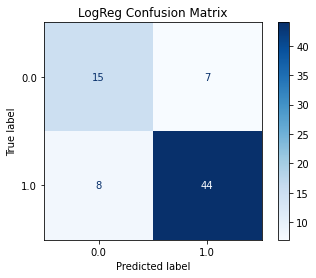

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues')
plt.title('LogReg Confusion Matrix');

In [20]:
pickle.dump(lr, open("models/logreg.pkl", "wb"))

In [22]:
lr_unpickled = pickle.load(open("models/logreg.pkl", "rb"))
lr_unpickled

LogisticRegression(max_iter=1000)

In [25]:
import basilica

BASILICA_KEY = 'c1fc650a-88e1-5b6d-b10d-ca793afb59ca'
BASILICA = basilica.Connection(BASILICA_KEY)

In [27]:
example_embedding = BASILICA.embed_sentence('Candiace is living too close to me now!', model='twitter')
example_embedding

[-0.384609,
 0.417315,
 0.621956,
 -0.275126,
 0.251947,
 0.182886,
 0.320817,
 0.505348,
 -0.525758,
 -0.31605,
 0.0286435,
 0.148713,
 0.156329,
 0.547177,
 0.099318,
 0.0282365,
 0.246344,
 0.474122,
 -0.0495732,
 -0.224875,
 -0.126167,
 -0.389319,
 0.0758009,
 -0.443852,
 0.136457,
 -0.0393661,
 0.361281,
 -0.138794,
 -0.00494331,
 0.131182,
 0.42399,
 -0.190462,
 0.31327,
 0.282382,
 -0.154094,
 -0.0976433,
 -0.0912806,
 -0.139229,
 -0.241239,
 0.0334525,
 -0.493131,
 0.0866104,
 -0.260523,
 -0.296511,
 -0.0454961,
 -0.325307,
 -3.61057,
 0.0422413,
 -0.587496,
 0.118705,
 -0.0965962,
 0.129633,
 0.754875,
 -0.0463702,
 0.236389,
 0.175733,
 -0.802986,
 -0.31797,
 -0.159194,
 0.179421,
 -0.189088,
 -0.00915021,
 -0.446495,
 0.37188,
 -0.571728,
 0.396563,
 0.65287,
 0.157175,
 -0.174713,
 -0.072114,
 0.0587959,
 0.202043,
 0.559394,
 0.337794,
 -0.194169,
 -0.506284,
 -0.192267,
 -0.171547,
 0.267119,
 0.554813,
 0.18397,
 0.280755,
 0.148178,
 0.215795,
 0.0170844,
 -0.38308,
 -0

In [31]:
lr_unpickled.predict(X_test)

array([0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])